In [1]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri('http://0.0.0.0:5000')
e = mlflow.set_experiment(data_config['mlflow_experiment_name'])

#mlflow.start_run(experiment_id=e.experiment_id)

2024-01-31 11:28:33.599125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 11:28:33.742777: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 11:28:33.742826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 11:28:33.742842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 11:28:33.768537: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 11:28:33.769465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
# fix paths
for k, v in data_config["paths"].items():
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [5]:
df = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df)

Fitting data ...


/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Data Viz

In [6]:
train, val = f.get_df()
data = pd.concat([train, val])

In [7]:
train.head()

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,0.0,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,0.0,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,0.0,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,0.0,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,0.0,348347.385084,False,False,False,True


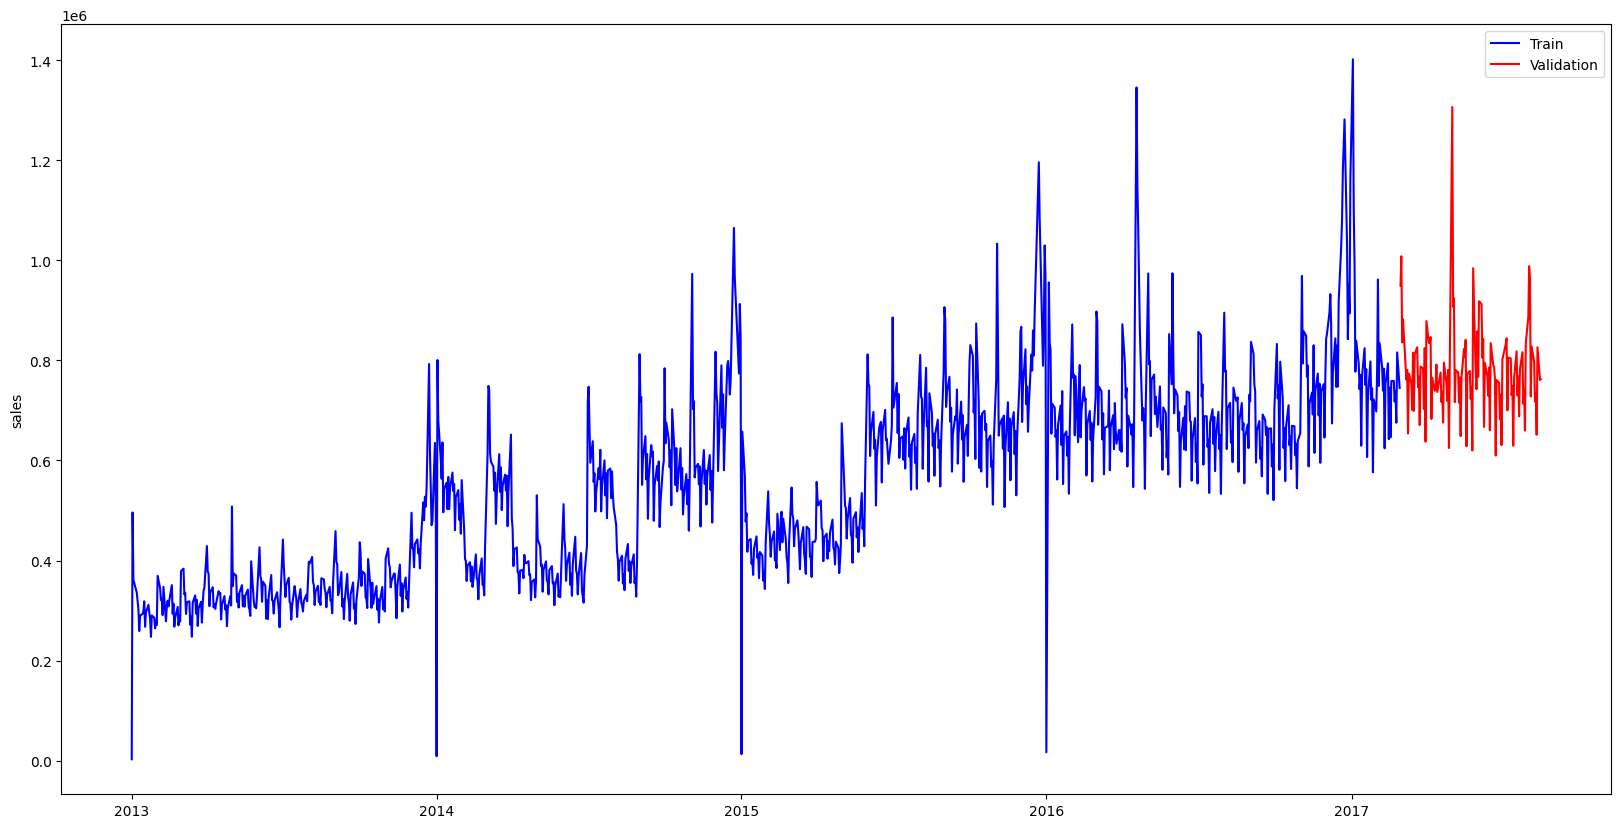

In [8]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [9]:
def predict_and_plot(model_name, scaled = False):
    #model_type = model_name.split(" ")[0]
    #model = model_name.split(" ")[1]
    local_config = config["prophet"]["default"]
    
    f.load_model(model_name, local_config)
    pred = f.predict(scaled=scaled)
    
    print(f"Predicted {len(pred)} days")
    
    assert len(pred) == len(val)
    
    df = pd.DataFrame(pred, columns=["yhat"])
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=df, x=val.index, y="yhat", color="red", label=f"{model_type} Prediction")
    sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")
    
    print(f"RMSE: {mean_squared_error(val['sales'], pred)}")
    
    return pred

## Prophet

In [22]:
mlflow.search_registered_models(filter_string="name = 'prophet default - 2024-01-31 10:24'")[0]['run_id']

TypeError: 'RegisteredModel' object is not subscriptable

In [10]:
predict_and_plot("prophet default - 2024-01-31 10:24")

RestException: INVALID_PARAMETER_VALUE: Invalid run ID: 'prophet default - 2024-01-31 10:24'

In [ ]:
predict_and_plot("prophet changepoint_prior_scale_0_5 - 2024-01-31 10:24")

KeyboardInterrupt: 

## Xgboost

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])

Predicted 169 days
RMSE: 19043832980.944557


array([1279401.4 ,  874193.6 ,  989367.7 ,  913365.2 ,  886591.9 ,
        922727.7 ,  899202.4 ,  819065.  ,  818799.94,  695936.75,
        701343.7 ,  716388.4 ,  736106.06,  726336.6 ,  718661.  ,
        724574.56,  695102.  ,  716855.06,  730875.75,  778984.4 ,
        732132.  ,  902010.  ,  742000.94,  687261.56,  714793.2 ,
        729348.7 ,  775553.2 ,  728700.8 ,  721025.2 ,  759613.3 ,
        710201.75,  750179.94,  779613.8 ,  826588.44,  762795.  ,
        824707.06,  822673.1 ,  780044.9 ,  775988.7 ,  737356.6 ,
        725944.94,  727596.  ,  727196.25,  749713.2 ,  747782.44,
       1056202.8 ,  865853.94,  937182.44,  996111.9 ,  994033.6 ,
       1000498.8 ,  972383.2 , 1085773.9 ,  740089.94,  772757.3 ,
        722354.25,  722538.56,  749449.8 ,  687861.44,  741930.1 ,
        767413.5 ,  828285.3 ,  975772.75,  772650.56,  803219.4 ,
        772274.4 ,  797154.4 ,  785029.4 ,  808956.7 ,  726232.9 ,
        710221.5 ,  722600.4 ,  683851.25,  755601.75,  722790

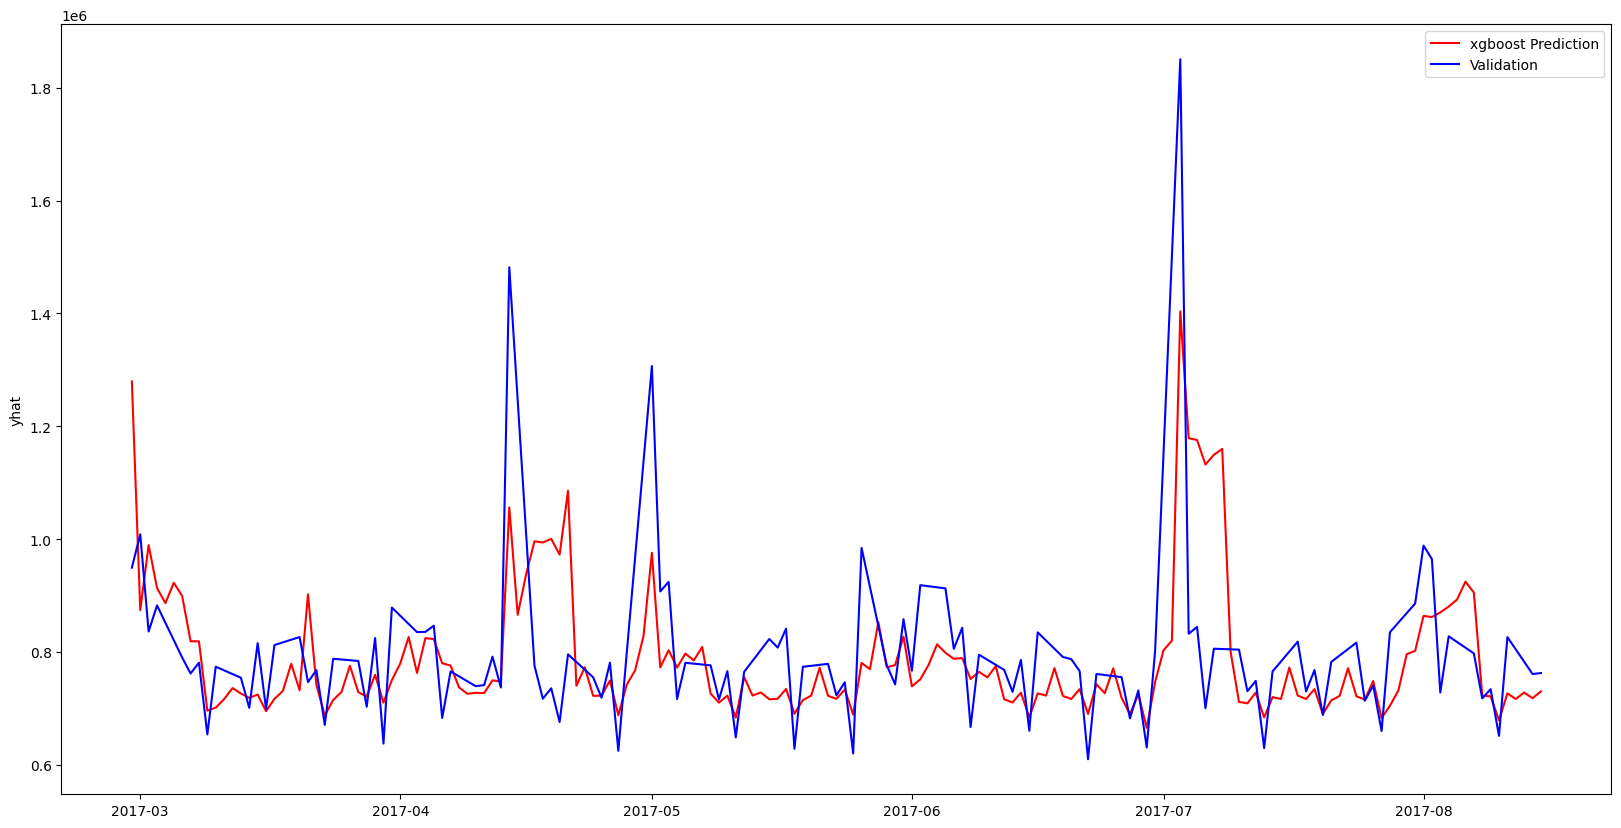

In [ ]:
predict_and_plot("xgboost default - 2024-01-31 10:23")

## LSTM simple

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


1/1 [==============================] - 0s 21ms/step
Predicted 169 days
RMSE: 52069011310.67308


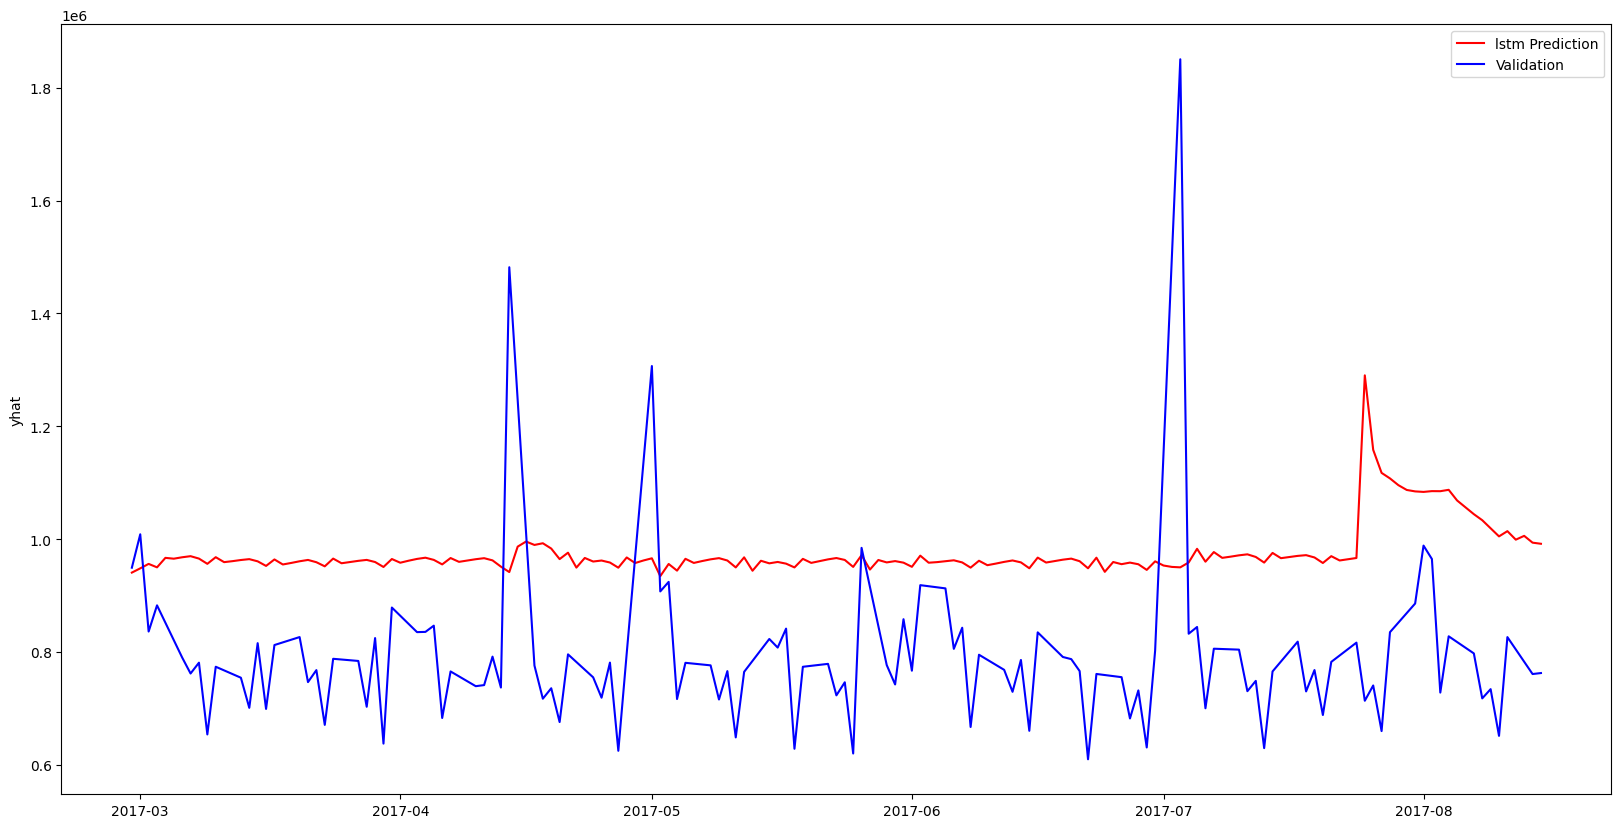

In [ ]:
predict_and_plot("lstm default_simple - 2024-01-31 09:48", True);

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


1/1 [==============================] - 0s 16ms/step
Predicted 169 days
RMSE: 38454548017.386826


[628737.94,
 665896.0,
 629186.8,
 666231.1,
 667557.06,
 668122.06,
 657420.75,
 626383.75,
 665777.25,
 627582.06,
 663265.1,
 659803.9,
 664085.44,
 658578.1,
 667578.5,
 667404.75,
 631417.5,
 666608.8,
 667967.06,
 630920.4,
 668491.25,
 638519.06,
 639978.7,
 696928.6,
 662581.8,
 699627.3,
 690345.8,
 671578.0,
 656237.06,
 638884.3,
 620894.0,
 668463.2,
 665341.1,
 671302.44,
 659349.56,
 663000.5,
 662393.06,
 624979.3,
 659901.44,
 658691.8,
 662797.8,
 660109.7,
 668171.2,
 669055.94,
 633032.1,
 668128.9,
 671321.0,
 629887.8,
 660779.0,
 626705.0,
 665775.44,
 628101.9,
 665348.5,
 666992.8,
 670078.1,
 664092.94,
 670680.4,
 666856.0,
 626781.9,
 659570.94,
 654961.25,
 656013.0,
 649740.2,
 616590.94,
 658130.44,
 626355.4,
 632001.75,
 643537.8,
 718929.2,
 739955.75,
 701556.75,
 757851.44,
 699325.8,
 743754.56,
 685202.56,
 767333.9,
 746981.94,
 681946.5,
 722707.3,
 684908.5,
 732384.9,
 730930.9,
 685958.7,
 735382.25,
 692498.3,
 742933.44,
 742437.2,
 698607.2,

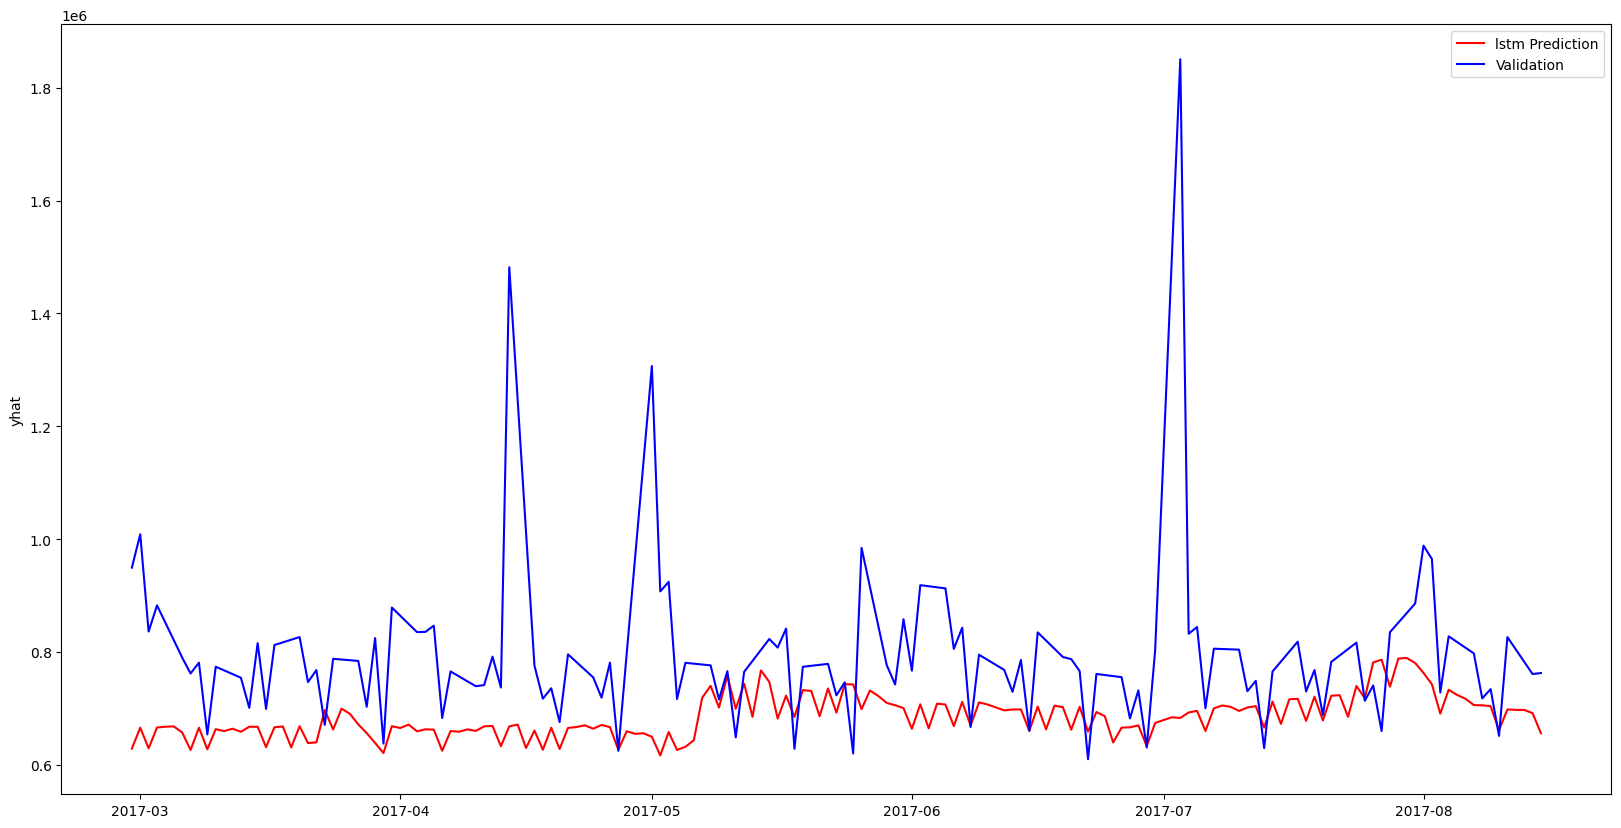

In [ ]:
predict_and_plot("lstm simple_default_l1_0_01_l2_0_01 - 2024-01-31 10:14")

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


1/1 [==============================] - 0s 20ms/step
RMSE: 29630148430.24259


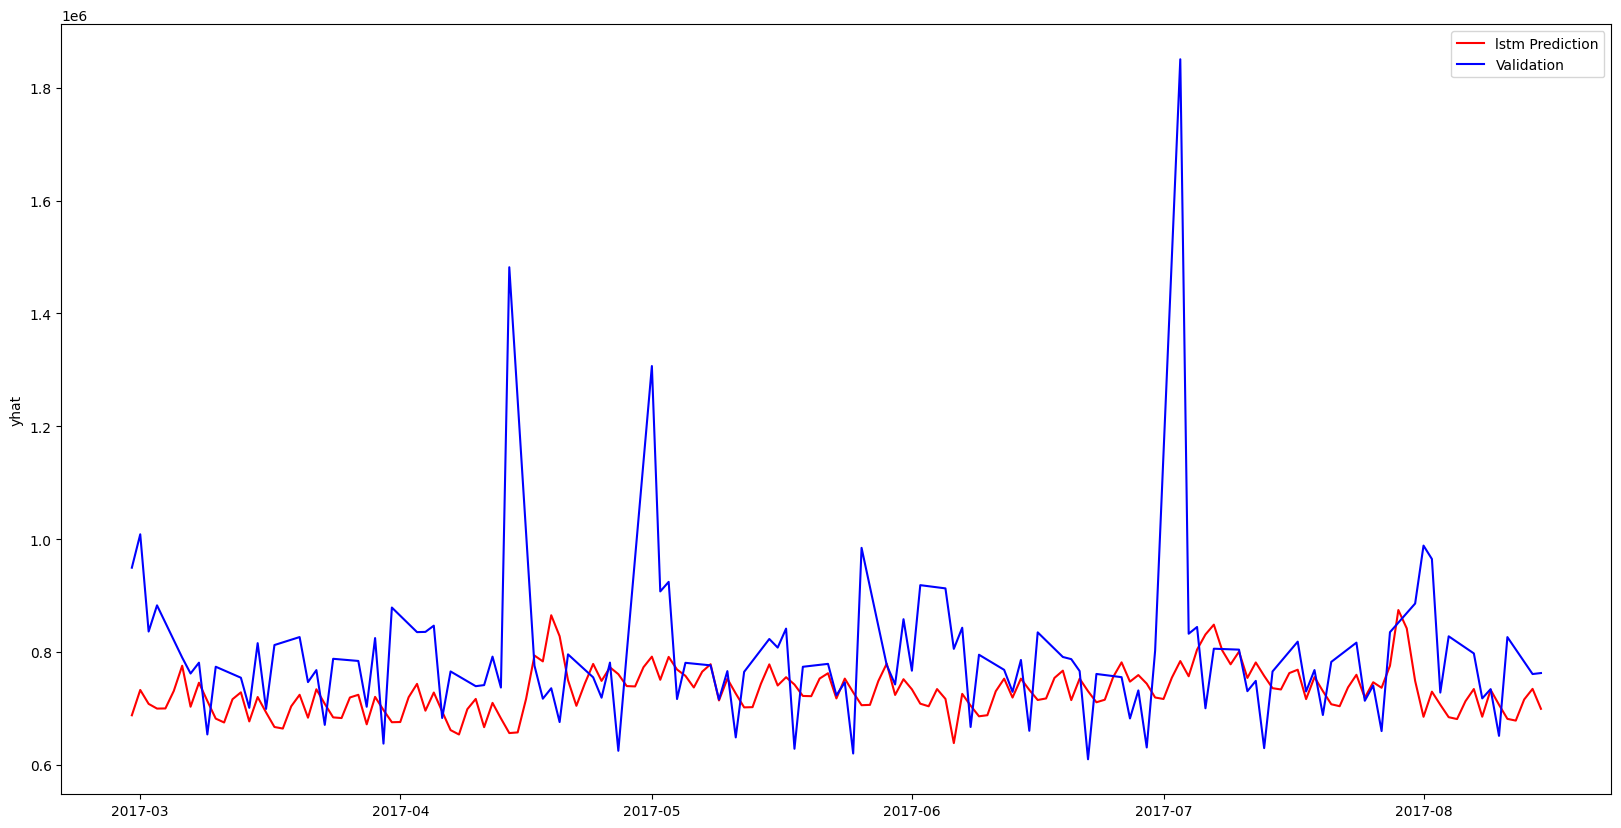

In [ ]:
predict_and_plot("lstm simple_batch_size_128_look_back_5 - 2024-01-31 10:10")

## LSTM multivariate

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])

1/1 [==============================] - 0s 17ms/step
Predicted 169 days
RMSE: 38454548017.386826


[628737.94,
 665896.0,
 629186.8,
 666231.1,
 667557.06,
 668122.06,
 657420.75,
 626383.75,
 665777.25,
 627582.06,
 663265.1,
 659803.9,
 664085.44,
 658578.1,
 667578.5,
 667404.75,
 631417.5,
 666608.8,
 667967.06,
 630920.4,
 668491.25,
 638519.06,
 639978.7,
 696928.6,
 662581.8,
 699627.3,
 690345.8,
 671578.0,
 656237.06,
 638884.3,
 620894.0,
 668463.2,
 665341.1,
 671302.44,
 659349.56,
 663000.5,
 662393.06,
 624979.3,
 659901.44,
 658691.8,
 662797.8,
 660109.7,
 668171.2,
 669055.94,
 633032.1,
 668128.9,
 671321.0,
 629887.8,
 660779.0,
 626705.0,
 665775.44,
 628101.9,
 665348.5,
 666992.8,
 670078.1,
 664092.94,
 670680.4,
 666856.0,
 626781.9,
 659570.94,
 654961.25,
 656013.0,
 649740.2,
 616590.94,
 658130.44,
 626355.4,
 632001.75,
 643537.8,
 718929.2,
 739955.75,
 701556.75,
 757851.44,
 699325.8,
 743754.56,
 685202.56,
 767333.9,
 746981.94,
 681946.5,
 722707.3,
 684908.5,
 732384.9,
 730930.9,
 685958.7,
 735382.25,
 692498.3,
 742933.44,
 742437.2,
 698607.2,

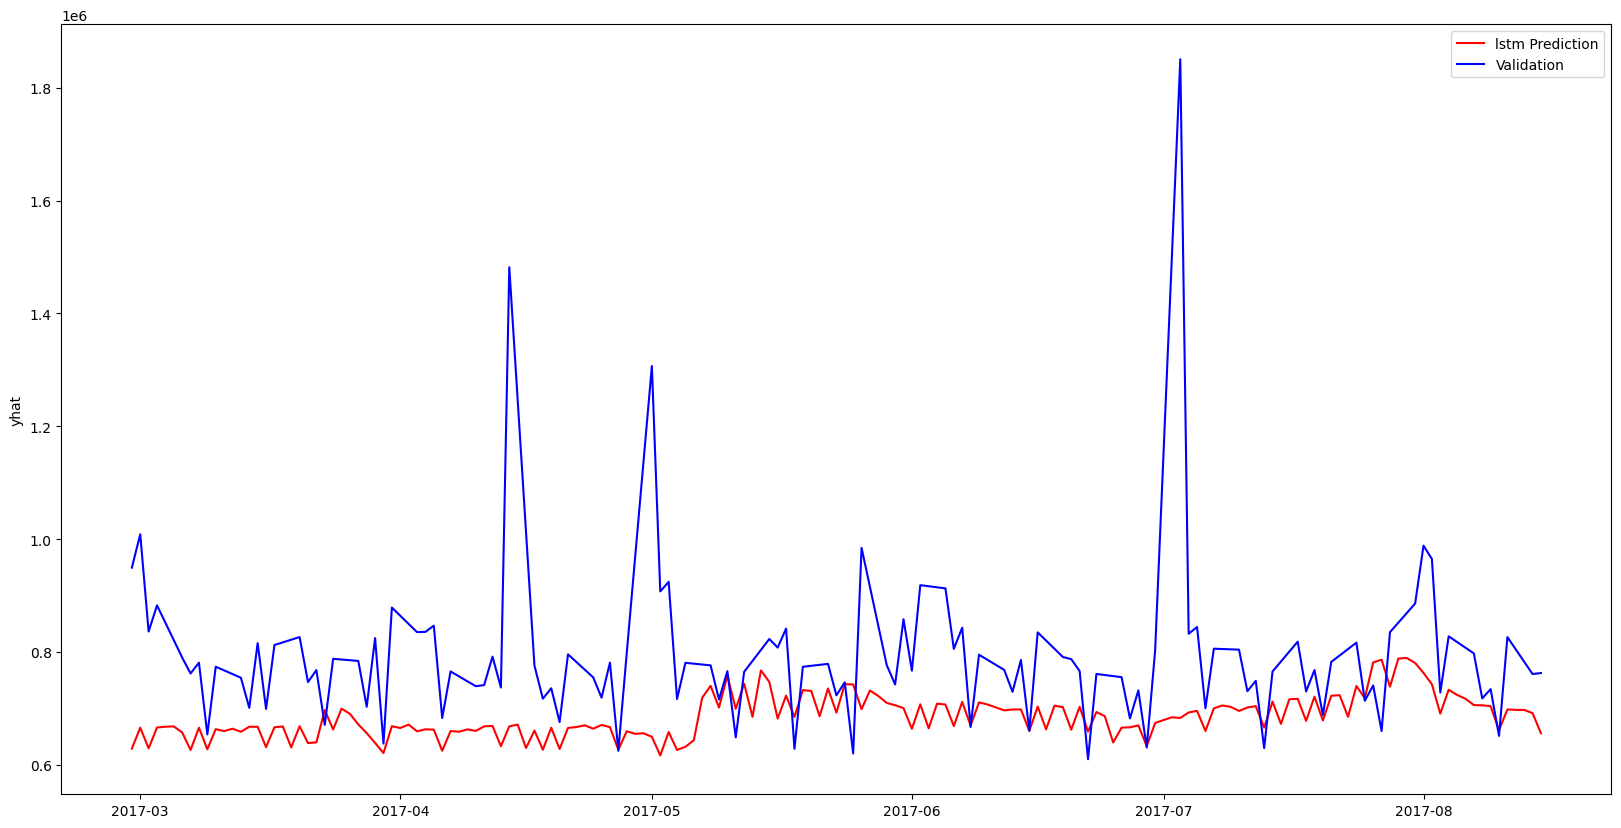

In [ ]:
predict_and_plot("lstm default_multivariate - 2024-01-31 09:56")

In [ ]:
predict_and_plot("lstm multivariate_batch_size_32_look_back_15 - 2024-01-31 10:04")